In [7]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
results = []

with open("benchmark_results.jsonl", encoding="utf-8") as f:
    for line in f:
        results.append(json.loads(line))

df = pd.DataFrame(results)
df.head()

,mode,id,query,expected,latency_ms,solved,ticket,error,parse_error,response
0,generative,1,No puedo instalar una impresora de red,solved,5284.7597,True,False,False,False,¡Hola! Soy tu asistente virtual y estoy aquí p...
1,generative,2,Quiero añadir una impresora compartida en la o...,solved,1668.8899,False,True,False,False,¡Entendido! Para instalar esa impresora compar...
2,generative,3,Antes imprimía y ahora no aparece la impresora,solved,1532.5467,True,False,False,False,¡Hola! Lamento que estés teniendo problemas co...
3,generative,4,La impresora no tira nada,solved,1730.6520,True,False,False,False,¡Hola! Soy tu asistente virtual y estoy aquí p...
4,generative,5,La impresora de tickets no imprime,solved,1738.2482,True,False,False,False,¡Hola! Entiendo que tienes problemas con tu im...


## Boxplot de latencia por modo

C:\Users\ralme\AppData\Local\Temp\ipykernel_103420\2870723608.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


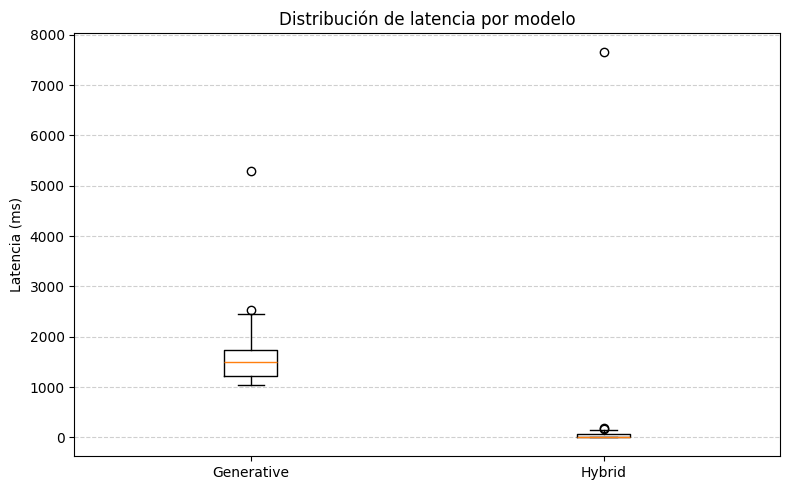

In [3]:
latency_generative = df[df["mode"] == "generative"]["latency_ms"]
latency_hybrid = df[df["mode"] == "hybrid"]["latency_ms"]

plt.figure(figsize=(8, 5))
plt.boxplot(
    [latency_generative, latency_hybrid],
    labels=["Generative", "Hybrid"],
    showfliers=True
)

plt.ylabel("Latencia (ms)")
plt.title("Distribución de latencia por modelo")

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Violin plot

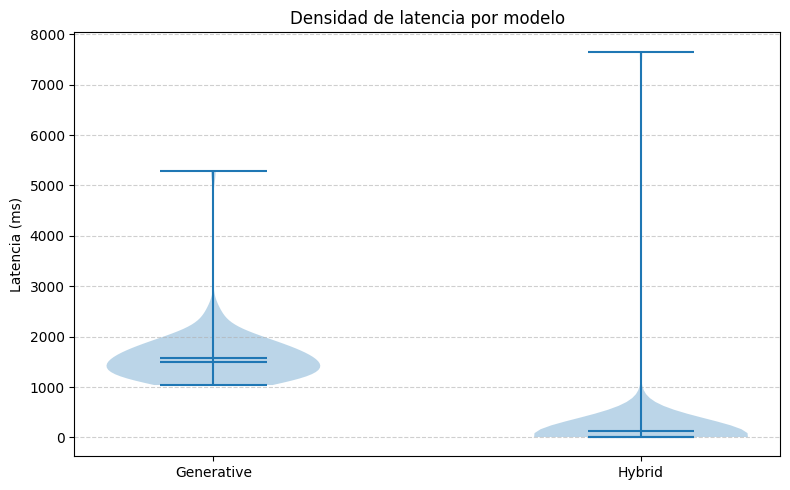

In [4]:
plt.figure(figsize=(8, 5))

plt.violinplot(
    [latency_generative, latency_hybrid],
    showmeans=True,
    showmedians=True
)

plt.xticks([1, 2], ["Generative", "Hybrid"])
plt.ylabel("Latencia (ms)")
plt.title("Densidad de latencia por modelo")

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [8]:
# Función para calcular métricas
def compute_metrics(df, mode):
    subset = df[df["mode"] == mode]
    total = len(subset)

    TP = FP = FN = TN = 0

    for _, r in subset.iterrows():
        expected = r["expected"]
        predicted = "solved" if r["solved"] else "ticket"

        if expected == "solved" and predicted == "solved":
            TP += 1
        elif expected == "ticket" and predicted == "solved":
            FP += 1
        elif expected == "solved" and predicted == "ticket":
            FN += 1
        elif expected == "ticket" and predicted == "ticket":
            TN += 1

    accuracy = (TP + TN) / total
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
    fnr = FN / (FN + TP) if (FN + TP) > 0 else 0

    return accuracy, fnr, fpr

# Calcular métricas
acc_gen, fnr_gen, fpr_gen = compute_metrics(df, "generative")
acc_hyb, fnr_hyb, fpr_hyb = compute_metrics(df, "hybrid")

acc_gen, fnr_gen, fpr_gen, acc_hyb, fnr_hyb, fpr_hyb

(0.9,
 0.15555555555555556,
 0.044444444444444446,
 0.7888888888888889,
 0.37777777777777777,
 0.044444444444444446)

## Barras agrupadas (Accuracy, FNR, FPR)

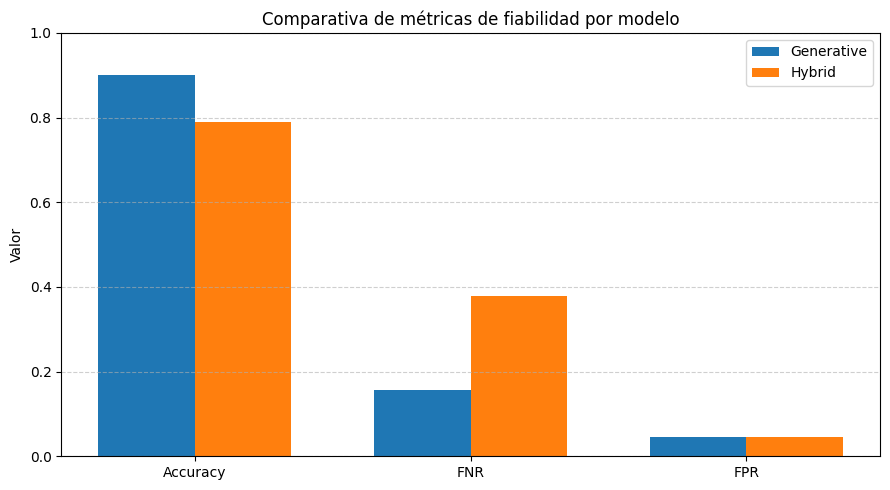

In [9]:
metrics = ["Accuracy", "FNR", "FPR"]

generative_values = [acc_gen, fnr_gen, fpr_gen]
hybrid_values = [acc_hyb, fnr_hyb, fpr_hyb]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(9, 5))

plt.bar(x - width/2, generative_values, width, label="Generative")
plt.bar(x + width/2, hybrid_values, width, label="Hybrid")

plt.xticks(x, metrics)
plt.ylabel("Valor")
plt.title("Comparativa de métricas de fiabilidad por modelo")
plt.ylim(0, 1)

plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## Matrices de confusión

In [10]:
def confusion_matrix_counts(df, mode):
    subset = df[df["mode"] == mode]

    TP = FP = FN = TN = 0

    for _, r in subset.iterrows():
        expected = r["expected"]
        predicted = "solved" if r["solved"] else "ticket"

        if expected == "solved" and predicted == "solved":
            TP += 1
        elif expected == "ticket" and predicted == "solved":
            FP += 1
        elif expected == "solved" and predicted == "ticket":
            FN += 1
        elif expected == "ticket" and predicted == "ticket":
            TN += 1

    return np.array([[TP, FN],
                     [FP, TN]])

cm_generative = confusion_matrix_counts(df, "generative")
cm_hybrid = confusion_matrix_counts(df, "hybrid")

cm_generative, cm_hybrid

(array([[38,  7],
        [ 2, 43]]),
 array([[28, 17],
        [ 2, 43]]))

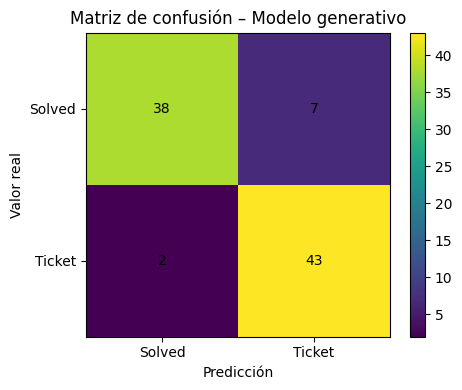

In [11]:
plt.figure(figsize=(5, 4))
plt.imshow(cm_generative)

plt.title("Matriz de confusión – Modelo generativo")
plt.xlabel("Predicción")
plt.ylabel("Valor real")

plt.xticks([0, 1], ["Solved", "Ticket"])
plt.yticks([0, 1], ["Solved", "Ticket"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_generative[i, j],
                 ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()

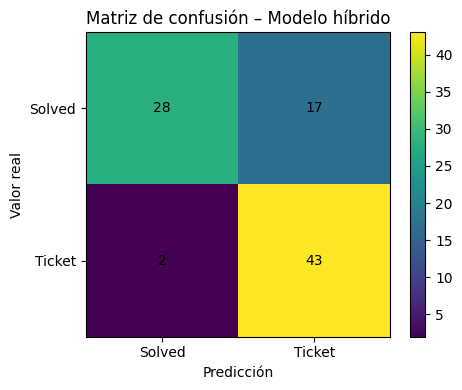

In [18]:
plt.figure(figsize=(5, 4))
plt.imshow(cm_hybrid)

plt.title("Matriz de confusión – Modelo híbrido")
plt.xlabel("Predicción")
plt.ylabel("Valor real")

plt.xticks([0, 1], ["Solved", "Ticket"])
plt.yticks([0, 1], ["Solved", "Ticket"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_hybrid[i, j],
                 ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()

## Cálculo del ticket rate por modelo

In [13]:
ticket_rate = (
    df.groupby("mode")["ticket"]
      .mean()
)

ticket_rate

mode
generative    0.555556
hybrid        0.666667
Name: ticket, dtype: float64

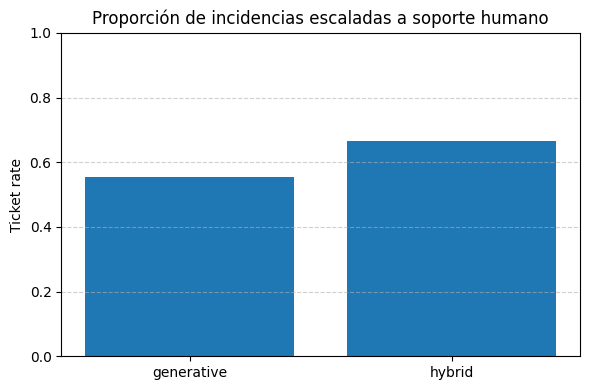

In [14]:
plt.figure(figsize=(6, 4))

plt.bar(ticket_rate.index, ticket_rate.values)

plt.ylabel("Ticket rate")
plt.title("Proporción de incidencias escaladas a soporte humano")
plt.ylim(0, 1)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Latencia vs decisión

In [15]:
df["decision"] = df["solved"].astype(int)

df[["mode", "latency_ms", "decision"]].head()

,mode,latency_ms,decision
0,generative,5284.7597,1
1,generative,1668.8899,0
2,generative,1532.5467,1
3,generative,1730.6520,1
4,generative,1738.2482,1


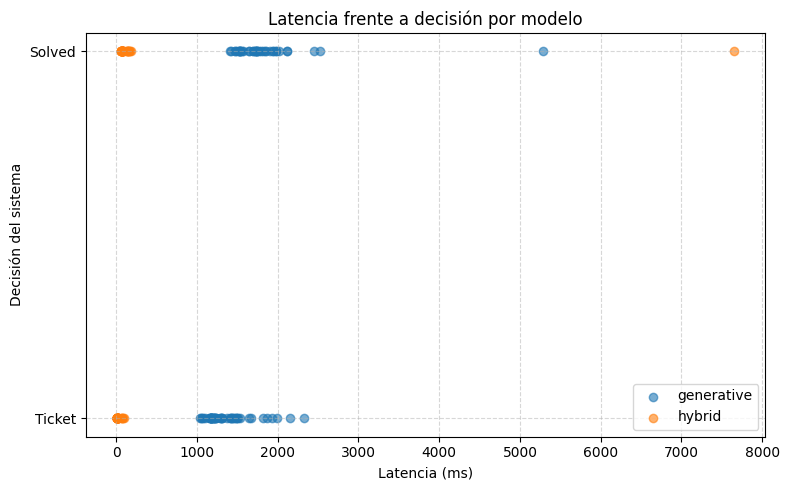

In [16]:
plt.figure(figsize=(8, 5))

for mode in df["mode"].unique():
    subset = df[df["mode"] == mode]
    plt.scatter(
        subset["latency_ms"],
        subset["decision"],
        alpha=0.6,
        label=mode
    )

plt.yticks([0, 1], ["Ticket", "Solved"])
plt.xlabel("Latencia (ms)")
plt.ylabel("Decisión del sistema")
plt.title("Latencia frente a decisión por modelo")

plt.legend()
plt.grid(axis="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()